In [2]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

print(now()-t00)

0:00:00.781243


In [3]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done, mounted
2020-11-09 17:51:48.882826


In [4]:
cd /content/drive/My Drive/BC-MRI-AE/

/content/drive/My Drive/BC-MRI-AE


In [4]:
# def load_MR_data(indir):
    
#     files = [file for file in os.listdir(indir) if '.npy' in file]; files.sort()
#     data = np.array([np.load(os.path.join(indir,file)) for file in files])
#     print(data.shape)
#     return data

# t0 = now();print(f"started {t0}")
# #SFARI_data = load_MR_data('./Data/SFARI-64iso-normed/')
# ABIDE_data = load_MR_data('./Data/ABIDE-64iso-normed/')
# print(ABIDE_data.shape)
# print(f"finished in {now()-t0}")

In [53]:
# def load_MR_data2(indir):
#   t0 = now()
# #indir = './Data/ABIDE-64iso-Nov9th/test2'
#   files = [file for file in os.listdir(indir) if '.npz' in file]; files.sort()
#   subs = ['-'.join((f.split('-')[0],f.split('-')[1])) for f in files]
#   data = np.array([np.load(os.path.join(indir,file))['arr'] for file in files])
#   print(f'elapsed time: {now()-t0}')
#   print(data.shape)

#   return data,subs
# data,subs = load_MR_data2('./Data/ABIDE-64iso-Nov9th/test2')

In [1]:
arr = np.load('../AbideDataForCAE.npz')
ABIDE_data = arr['arr_0']
subs = arr['arr_1']
nsubs = len(subs)

NameError: ignored

In [ ]:
ABIDE_data = np.array([(ABIDE_data-ABIDE_data[0,:,:,:].min()) / (ABIDE_data[0,:,:,:].max()-ABIDE_data[0,:,:,:].min()) for s in range(nsubs)])

(1060, 28, 28, 3)


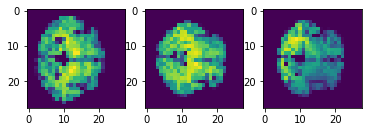

In [6]:
# BUILD DATA
import cv2 

nsubs = ABIDE_data.shape[0]
mid_idx = np.array([ABIDE_data[s,:,:,:].sum(axis=0).sum(axis=0).argmax() for s in range(1060)])
ABIDE_data_temp = np.array([ABIDE_data[s,:,:,mid_idx[s]-1:mid_idx[s]+2] for s in range(nsubs)])

targSize = (28,28)

ABIDE_data_3d = np.zeros((ABIDE_data_temp.shape[0],targSize[0],targSize[1],ABIDE_data_temp.shape[-1]))

for s in range(ABIDE_data_3d.shape[0]):
  for c in range(ABIDE_data_3d.shape[-1]):
    ABIDE_data_3d[s,:,:,c] = cv2.resize(ABIDE_data_temp[s,:,:,c],targSize)


print(ABIDE_data_3d.shape)

plt.subplot(1,3,1)
plt.imshow(ABIDE_data_3d[0,:,:,0])

plt.subplot(1,3,2)
plt.imshow(ABIDE_data_3d[60,:,:,0])

plt.subplot(1,3,3)
plt.imshow(ABIDE_data_3d[150,:,:,0])

In [7]:
from contrastive_vae.celeb_utils import get_celeb_vae

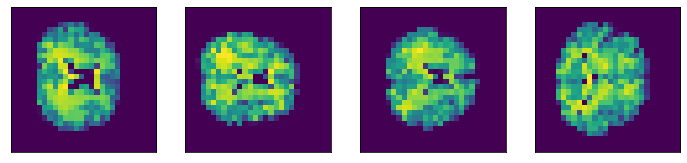

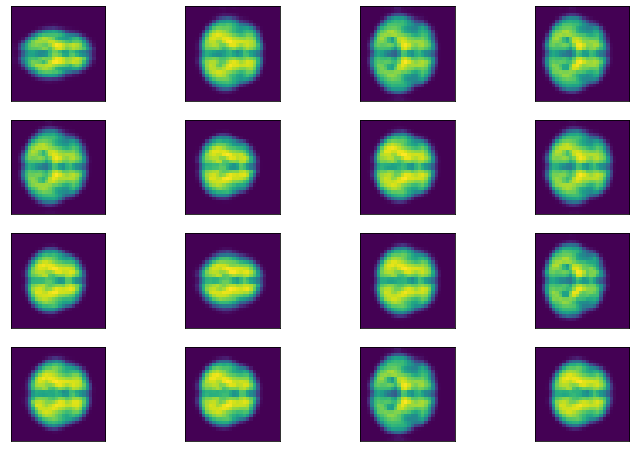

In [8]:
height = 28;width = 28;nchannels = 3;latent_dim = 2;batch_size = 64 
i,j,k=20,20,30

encoder, decoder, vae = get_celeb_vae(input_shape=(height, width, nchannels), latent_dim=latent_dim, batch_size=batch_size, disentangle=False, gamma=1)

for i in range(1000):
  #vae.train_on_batch(data_batch)
  vae.train_on_batch(ABIDE_data_3d[np.random.randint(0,1060,batch_size),:,:,:])

plt.figure(figsize=(12,8))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(ABIDE_data_3d[np.random.randint(1,high=1060),:,:,0])
  plt.xticks([]);plt.yticks([])

plt.figure(figsize=(12,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(decoder.predict(np.random.randn(1,latent_dim))[0,:,:,0])
  plt.xticks([]);plt.yticks([])


In [9]:
import pandas as pd
df = pd.read_csv('./CSVs/ABIDE-legend.csv')
good_subs = np.load('abide_good_subs.npy')

df = df.iloc[np.array([df['BIDS_ID'].values[s] in good_subs for s in range(len(df))])]
df = df.iloc[0:1060]

In [10]:
TD_subs = ABIDE_data_3d[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data_3d[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(540, 28, 28, 3)
(494, 28, 28, 3)


In [11]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2
dxArr

array([2., 1., 1., ..., 1., 2., 2.])

In [12]:
from contrastive_vae.celeb_utils import get_celeb_cvae

In [13]:
height = 28;width = 28;nchannels = 3;latent_dim = 2;batch_size = 64 ;latent_dim_s = 4
i,j,k=20,20,30

cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_celeb_cvae(input_shape=(width, height, 3), latent_dim=latent_dim, bias=True, disentangle=True, gamma=1)

for i in range(1000):
#cvae.train_on_batch([tg_images, bg_images])
  cvae.train_on_batch([DX_subs[np.random.randint(0,DX_subs.shape[0],batch_size),:,:,:],TD_subs[np.random.randint(0,TD_subs.shape[0],batch_size),:,:,:]])


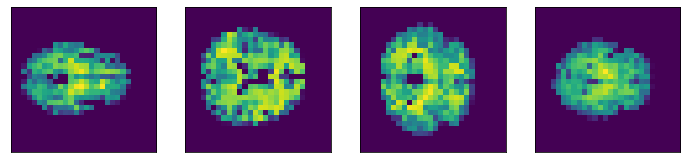

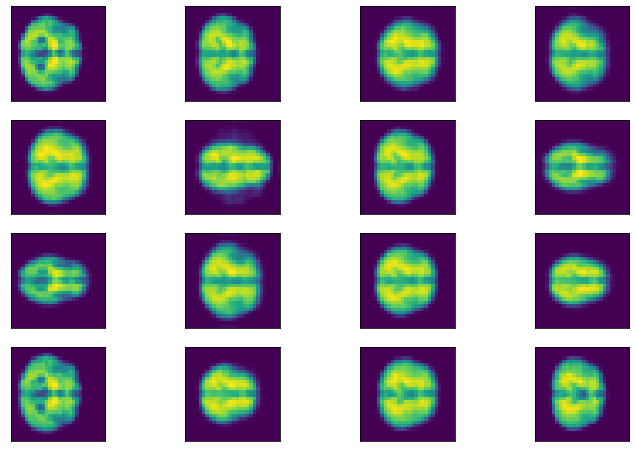

In [14]:
plt.figure(figsize=(12,8))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(ABIDE_data_3d[np.random.randint(1,high=1060),:,:,0])
  plt.xticks([]);plt.yticks([])

plt.figure(figsize=(12,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(cvae_decoder.predict(np.random.randn(1,4))[0,:,:,0])
  plt.xticks([]);plt.yticks([])

([<matplotlib.axis.XTick at 0x7fbf74301f60>,
 [Text(0, 0, 'background'), Text(0, 0, 'salient'), Text(0, 0, 'vae')])

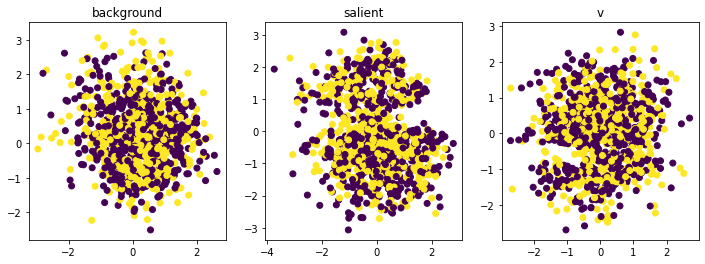

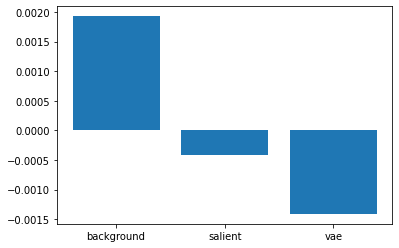

In [15]:
from sklearn.metrics import silhouette_score

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
z_mean, z_log_var, z = z_encoder(ABIDE_data_3d[:,:,:,:])
x = z
plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.title('background')

plt.subplot(1,3,2)
s_mean, s_log_var, s = s_encoder(ABIDE_data_3d[:,:,:,:])
x = s
plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.title('salient')

plt.subplot(1,3,3)
v = encoder(ABIDE_data_3d[:,:,:,:])[2]
x = v
plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.title('v')

plt.figure(figsize=(6,4))
plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)])
plt.xticks([0,1,2],labels=['background','salient','vae'])